## Imports / Data Preparation

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import tarfile
import random
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [4]:
# To safely store your training progress, use Google Drive:
#from google.colab import drive
#drive.mount('/content/drive')

In [5]:
tf.device('/GPU:0')

Download CIFAR-10 dataset from the source:

In [6]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz

'wget' is not recognized as an internal or external command,
operable program or batch file.


tar: Error opening archive: Failed to open 'cifar-10-python.tar.gz'


### Preprocessing

In [7]:
def load_cifar10_batch(batch_filename):
    with open(batch_filename, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        X = dict[b'data']
        Y = dict[b'labels']
        X = X.reshape(-1, 3, 32, 32).astype("float32")
        X = np.transpose(X, (0, 2, 3, 1))  # Convert to NHWC
        Y = np.array(Y)
        return X, Y

def load_cifar10(data_dir):
    X_train = []
    Y_train = []
    # There are 5 training batches
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        X, Y = load_cifar10_batch(batch_file)
        X_train.append(X)
        Y_train.append(Y)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    # Load test batch
    X_test, Y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    return X_train, Y_train, X_test, Y_test

# Specify the path to the extracted CIFAR-10 data
data_dir = 'cifar-10-batches-py'  # Change this path if different

# Load the data
X_train, Y_train, X_test, Y_test = load_cifar10(data_dir)

print(f"Training data shape: {X_train.shape}, Training labels shape: {Y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {Y_test.shape}")

FileNotFoundError: [Errno 2] No such file or directory: 'cifar-10-batches-py\\data_batch_1'

In [ ]:
# Prepare the dataset
def preprocess_data(X, Y):
    X = X / 255.0  # Normalize to [0,1]
    X = X.astype(np.float32)
    Y = Y.astype(np.int32)
    return X, Y

X_train_p, Y_train_p = preprocess_data(X_train, Y_train)
X_test_p, Y_test_p = preprocess_data(X_test, Y_test)


### Important constants/hyperparameters

Some constants/information about the dataset:

In [ ]:
# Hyperparameters
batch_size = 128
learning_rate = 1e-4

In [ ]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_p, Y_train_p))
train_dataset = train_dataset.shuffle(buffer_size=50000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_p, Y_test_p))
test_dataset = test_dataset.batch(batch_size)

In [ ]:
image_shape = X_train.shape[1:] # Shape of CIFAR-10 images
image_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']
n_class = len(image_labels)  # Number of classes

### Data Visualization

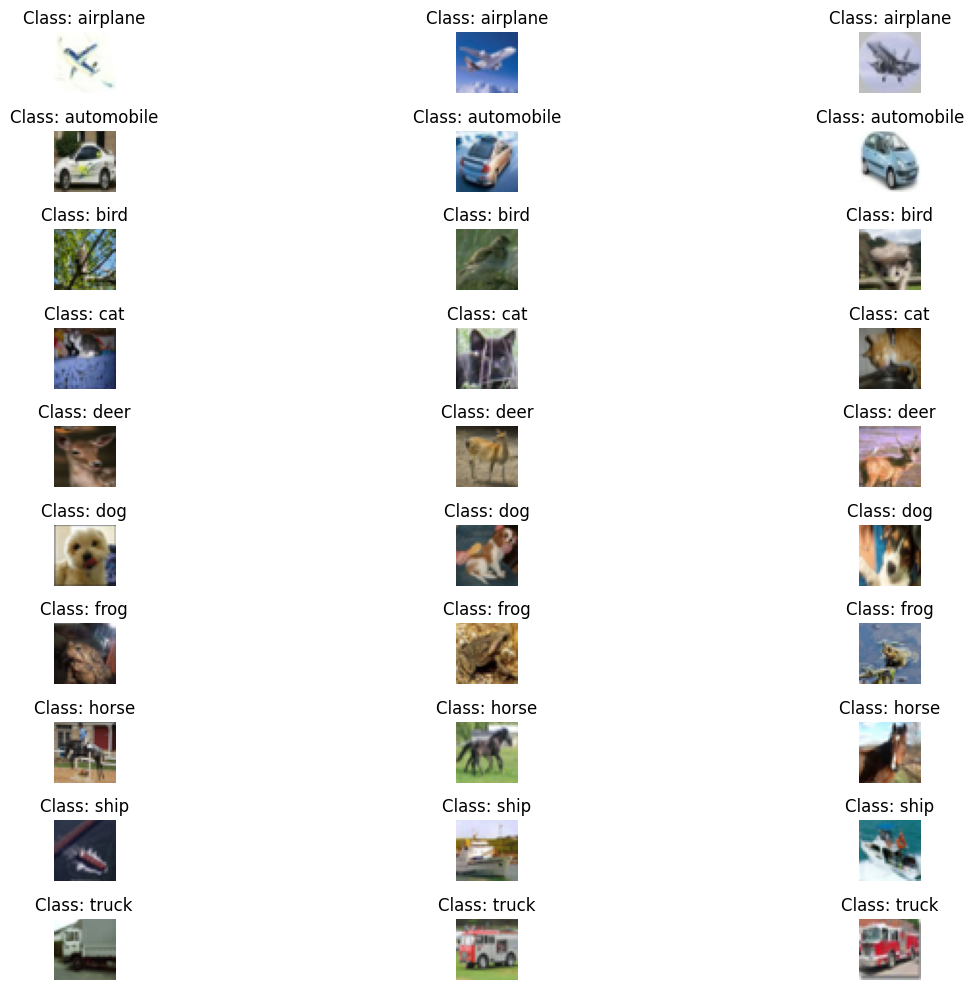

In [ ]:
# [Q1]
def visualize_samples(X, Y, num_samples=16):
    # Create a figure with subplots for each class
    plt.figure(figsize=(15, 10))

    # Get unique classes
    unique_classes = np.unique(Y)

    # For each class, show 3 samples
    for i, class_idx in enumerate(unique_classes):
        # Get indices of samples for this class
        class_indices = np.where(Y == class_idx)[0]

        # Randomly select 3 samples for this class
        selected_indices = np.random.choice(class_indices, size=3, replace=False)

        # Plot each sample
        for j, idx in enumerate(selected_indices):
            plt.subplot(len(unique_classes), 3, i*3 + j + 1)
            plt.imshow(X[idx])
            plt.title(f'Class: {image_labels[class_idx]}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize training samples
visualize_samples(X_train_p, Y_train_p)

## Classification Task

### Model

In [ ]:
# [C1]
class ResBlock(tf.keras.layers.Layer):
    def __init__(self, in_channels, out_channels, downsampling):
        super(ResBlock, self).__init__()
        stride = 2 if downsampling else 1

        self.conv1 = layers.Conv2D(out_channels, kernel_size=3, strides=stride, padding='same', use_bias=True)
        self.act1 = layers.LeakyReLU()
        self.conv2 = layers.Conv2D(out_channels, kernel_size=3, strides=1, padding='same', use_bias=True)
        self.act2 = layers.LeakyReLU()

        self.shortcut = (
            layers.Conv2D(out_channels, kernel_size=1, strides=stride, padding='same', use_bias=False)
            if in_channels != out_channels or downsampling else lambda x: x
        )

    def call(self, x):
        shortcut = self.shortcut(x)
        x = self.act1(self.conv1(x))
        x = self.conv2(x)
        return self.act2(x + shortcut)


In [ ]:
# [C2]
class WRN(tf.keras.Model):
    def __init__(self, num_classes: int = 10):
        super(WRN, self).__init__()
        self.num_classes = num_classes

        # WRN-16-4 architecture: 16 layers with widening factor 4
        # Initial convolution layer — FIXED to 16 channels
        self.conv1 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', use_bias=True)

        # Stage 1: 64 channels (16×4), 2 blocks
        self.stage1_block1 = ResBlock(16, 64, downsampling=False)
        self.stage1_block2 = ResBlock(64, 64, downsampling=False)

        # Stage 2: 128 channels, 2 blocks
        self.stage2_block1 = ResBlock(64, 128, downsampling=True)
        self.stage2_block2 = ResBlock(128, 128, downsampling=False)

        # Stage 3: 256 channels, 2 blocks
        self.stage3_block1 = ResBlock(128, 256, downsampling=True)
        self.stage3_block2 = ResBlock(256, 256, downsampling=False)

        # Global Average Pooling and Dense layer
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dense = layers.Dense(num_classes)

    def call(self, x):
        # Initial convolution
        x = self.conv1(x)

        # Stage 1
        x = self.stage1_block1(x)
        x = self.stage1_block2(x)

        # Stage 2
        x = self.stage2_block1(x)
        x = self.stage2_block2(x)

        # Stage 3
        x = self.stage3_block1(x)
        x = self.stage3_block2(x)

        # Global Average Pooling and output layer
        x = self.global_avg_pool(x)
        x = self.dense(x)

        return x


# =======================
# Instantiate the model and count parameters
n_class = 10
model = WRN(num_classes=n_class)

# Create input tensor and run model to build all layers
dummy_input = tf.ones((1, 32, 32, 3))
_ = model(dummy_input)

# Count trainable parameters
total_params = 0
for variable in model.trainable_variables:
    shape = variable.shape
    variable_params = 1
    for dim in shape:
        variable_params *= dim
    total_params += variable_params
    print(f"Variable shape: {shape}, params: {variable_params}")

print(f"[Q2] Total trainable parameters: {total_params:,}")

Variable shape: (3, 3, 3, 16), params: 432
Variable shape: (16,), params: 16
Variable shape: (3, 3, 16, 64), params: 9216
Variable shape: (64,), params: 64
Variable shape: (3, 3, 64, 64), params: 36864
Variable shape: (64,), params: 64
Variable shape: (1, 1, 16, 64), params: 1024
Variable shape: (3, 3, 64, 64), params: 36864
Variable shape: (64,), params: 64
Variable shape: (3, 3, 64, 64), params: 36864
Variable shape: (64,), params: 64
Variable shape: (3, 3, 64, 128), params: 73728
Variable shape: (128,), params: 128
Variable shape: (3, 3, 128, 128), params: 147456
Variable shape: (128,), params: 128
Variable shape: (1, 1, 64, 128), params: 8192
Variable shape: (3, 3, 128, 128), params: 147456
Variable shape: (128,), params: 128
Variable shape: (3, 3, 128, 128), params: 147456
Variable shape: (128,), params: 128
Variable shape: (3, 3, 128, 256), params: 294912
Variable shape: (256,), params: 256
Variable shape: (3, 3, 256, 256), params: 589824
Variable shape: (256,), params: 256
Varia

### Part 1 Training

In [ ]:
# [C3]
def part1_train_step(optim : optimizers.Optimizer, model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor, sigma : float = 0.03) -> dict:

    # implement code here
    # preprocessing
    # 1. Convert label to one-hot encoding and add Gaussian noise to image data
    y = tf.one_hot(label, model.num_classes)
    x = tf.keras.layers.GaussianNoise(stddev=sigma)(data, training=True)

    # =======================

    # train model
    with tf.GradientTape() as g:

        # implement code here
        # calculate loss here
        # 2. Compute logits and categorical cross entropy loss
        logits = model(x)
        loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(
            y, logits, from_logits=True
        ))
        # =======================

    # implement code here
    # obtain the gradients and apply them (using optimizer)
    # 3. Get gradients of loss with respect to model's trainable variables
    gradients = g.gradient(loss, model.trainable_variables)

    # 4. Apply gradients using the optimizer
    optim.apply_gradients(zip(gradients, model.trainable_variables))
    # =======================

    # implement code here
    # return loss (or other values if needed)
    # 5. Return the loss as a dictionary
    return {
        "loss": loss.numpy()
    }
    # =======================

In [ ]:
def train_loop_1(model, optimizer, train_step, epochs : int = 20, save_interval : int = 5):
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        num_batches = 0

        # Wrap the training dataset with tqdm to create a progress bar
        with tqdm(train_dataset, unit="batch") as tepoch:
            for step, (batch_x, batch_y) in enumerate(tepoch):
                # Execute a train step and get the losses
                loss_dict = train_step(optimizer, model, batch_x, batch_y)
                epoch_loss += loss_dict["loss"]

                # Accumulate number of batches (for average loss calculation)
                num_batches += 1

                # Update the progress bar description with the current loss
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(**loss_dict)

        # # Uncomment to test accuracy during training (Implement that first!)
        test_accuracy = evaluate_accuracy(model, test_dataset)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

        # Feel free to modify this to save your progress somewhere else
        if epoch % save_interval == 0:
            model.save_weights(f'model-{epoch}.weights.h5')


### Evaluation

In [ ]:
# [C4]
def evaluate_accuracy(model, dataset):
    correct = 0
    total = 0
    # Wrap the dataset with tqdm to create a progress bar
    with tqdm(dataset, unit="batch") as tepoch:
        tepoch.set_description(f"Evaluating")
        for batch_x, batch_y in tepoch:
            batch_size = tf.shape(batch_x)[0]

            # implement code here
            # Compute logits
            logits = model(batch_x)
            predictions = tf.argmax(logits, axis=1)
            # =======================

            # implement code here
            # Cast batch_y to int64 to match preds data type
            batch_y = tf.cast(batch_y, tf.int64)
            predictions = tf.cast(predictions, tf.int64)

            # Count correct predictions
            correct_batch = tf.reduce_sum(tf.cast(tf.equal(predictions, batch_y), tf.int32))
            correct += correct_batch
            total += batch_size
            # =======================

            # implement code here
            # Update the progress bar description
            current_accuracy = tf.cast(correct, tf.float32) / tf.cast(total, tf.float32)
            tepoch.set_postfix(accuracy=f"{current_accuracy.numpy():.4f}")
            # =======================

    accuracy = tf.cast(correct, tf.float32) / tf.cast(total, tf.float32)
    return accuracy.numpy()

evaluate_accuracy(model, test_dataset)


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 21.38batch/s, accuracy=0.1000]


np.float32(0.1)

### Execute training

In [ ]:
# Instantiate the model
model = WRN(num_classes=n_class)

# Define the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)

### Regularization

In [ ]:
train_loop_1(model, optimizer, part1_train_step, 20)

Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s, accuracy=0.4277]


Test Accuracy: 42.77%
Epoch 1, Average Loss: 1.7884


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.45batch/s, accuracy=0.5102]


Test Accuracy: 51.02%
Epoch 2, Average Loss: 1.4612


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 30.43batch/s, accuracy=0.5646]


Test Accuracy: 56.46%
Epoch 3, Average Loss: 1.2974


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s, accuracy=0.5871]


Test Accuracy: 58.71%
Epoch 4, Average Loss: 1.1750


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s, accuracy=0.6228]


Test Accuracy: 62.28%
Epoch 5, Average Loss: 1.0761


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 30.00batch/s, accuracy=0.6359]


Test Accuracy: 63.59%
Epoch 6, Average Loss: 1.0102


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 30.20batch/s, accuracy=0.6288]


Test Accuracy: 62.88%
Epoch 7, Average Loss: 0.9563


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 30.82batch/s, accuracy=0.6809]


Test Accuracy: 68.09%
Epoch 8, Average Loss: 0.9073


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 30.29batch/s, accuracy=0.6893]


Test Accuracy: 68.93%
Epoch 9, Average Loss: 0.8568


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 30.66batch/s, accuracy=0.7028]


Test Accuracy: 70.28%
Epoch 10, Average Loss: 0.8111


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s, accuracy=0.7036]


Test Accuracy: 70.36%
Epoch 11, Average Loss: 0.7710


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s, accuracy=0.7208]


Test Accuracy: 72.08%
Epoch 12, Average Loss: 0.7386


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s, accuracy=0.7233]


Test Accuracy: 72.33%
Epoch 13, Average Loss: 0.6975


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s, accuracy=0.7407]


Test Accuracy: 74.07%
Epoch 14, Average Loss: 0.6680


Evaluating: 100%|██████████| 79/79 [00:02<00:00, 30.27batch/s, accuracy=0.7253]


Test Accuracy: 72.53%
Epoch 15, Average Loss: 0.6332


Evaluating: 100%|██████████| 79/79 [00:03<00:00, 25.33batch/s, accuracy=0.7562]


Test Accuracy: 75.62%
Epoch 16, Average Loss: 0.6046


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.47batch/s, accuracy=0.7678]


Test Accuracy: 76.78%
Epoch 17, Average Loss: 0.5825


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s, accuracy=0.7753]


Test Accuracy: 77.53%
Epoch 18, Average Loss: 0.5466


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s, accuracy=0.7863]


Test Accuracy: 78.63%
Epoch 19, Average Loss: 0.5212


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s, accuracy=0.7806]

Test Accuracy: 78.06%
Epoch 20, Average Loss: 0.5007


Evaluating: 100%|██████████| 79/79 [00:05<00:00, 15.48batch/s, accuracy=0.7806]


[Q5] Test accuracy: 78.06%


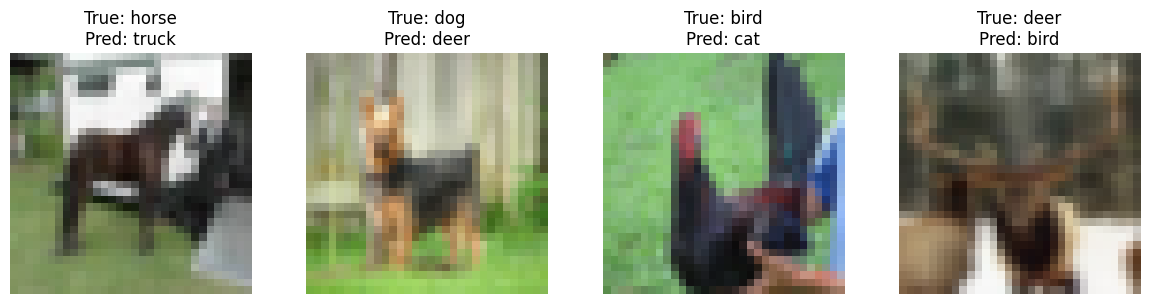

In [ ]:
# [Q5] Report the accuracy of the test dataset and show at least 4 misclassified samples

# Evaluating the model on test dataset
# Make sure model is defined and trained before this point
test_accuracy = evaluate_accuracy(model, test_dataset)
print(f"[Q5] Test accuracy: {test_accuracy * 100:.2f}%")

# Finding and displaying misclassified samples
misclassified_samples = []
misclassified_predictions = []
misclassified_labels = []

# Collecting misclassified examples from a limited portion of the test dataset
for batch_x, batch_y in test_dataset.take(5):  # Only look at a few batches to save time
    logits = model(batch_x)
    predictions = tf.argmax(logits, axis=1)

    # Find misclassified examples in this batch
    for i in range(len(batch_x)):
        pred = predictions[i].numpy()
        true_label = batch_y[i].numpy()

        if pred != true_label:
            misclassified_samples.append(batch_x[i].numpy())
            misclassified_predictions.append(pred)
            misclassified_labels.append(true_label)

            # If we've found enough examples, break
            if len(misclassified_samples) >= 4:
                break

    # If we've found enough examples, break
    if len(misclassified_samples) >= 4:
        break

# Display misclassified examples
plt.figure(figsize=(12, 3))
for i in range(min(4, len(misclassified_samples))):
    plt.subplot(1, 4, i+1)
    plt.imshow(misclassified_samples[i])
    plt.title(f"True: {image_labels[misclassified_labels[i]]}\nPred: {image_labels[misclassified_predictions[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# [C5] Implement your regularization method here

class ResBlockRE(tf.keras.Model):
    def __init__(self, in_channels : int, out_channels : int, downsampling = False):
        super(ResBlockRE, self).__init__()

        # Set stride for downsampling if needed
        stride = 2 if downsampling else 1

        # Main branch (F(x)) with Batch Normalization and Dropout
        self.leaky_relu1 = layers.LeakyReLU()
        self.conv1 = layers.Conv2D(out_channels, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(0.2)

        self.leaky_relu2 = layers.LeakyReLU()
        self.conv2 = layers.Conv2D(out_channels, kernel_size=3, strides=stride, padding='same', use_bias=False)
        self.bn2 = layers.BatchNormalization()
        self.dropout2 = layers.Dropout(0.2)

        # Skip connection with Batch Normalization
        if in_channels != out_channels or downsampling:
            self.skip = layers.Conv2D(out_channels, kernel_size=1, strides=stride, padding='same', use_bias=False)
            self.bn_skip = layers.BatchNormalization()
        else:
            self.skip = layers.Lambda(lambda x: x)
            self.bn_skip = layers.Lambda(lambda x: x)

    def call(self, x, training=True):
        # Main branch
        out = self.leaky_relu1(x)
        out = self.conv1(out)
        out = self.bn1(out, training=training)
        out = self.dropout1(out, training=training)

        out = self.leaky_relu2(out)
        out = self.conv2(out)
        out = self.bn2(out, training=training)
        out = self.dropout2(out, training=training)

        # Skip connection
        skip = self.skip(x)
        skip = self.bn_skip(skip, training=training)

        # Combine main branch with skip connection
        return out + skip

class WRNRE(tf.keras.Model):
    def __init__(self, num_classes : int = 10):
        super(WRNRE, self).__init__()
        self.num_classes = num_classes

        # Initial convolution layer with Batch Normalization and Dropout
        self.conv1 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same', use_bias=False)
        self.bn1 = layers.BatchNormalization()
        self.dropout1 = layers.Dropout(0.2)

        # Stage 1: Block group with 16*4=64 channels (3 blocks)
        self.stage1_block1 = ResBlockRE(16, 64, downsampling=False)
        self.stage1_block2 = ResBlockRE(64, 64, downsampling=False)
        self.stage1_block3 = ResBlockRE(64, 64, downsampling=False)

        # Stage 2: Block group with 32*4=128 channels (3 blocks)
        self.stage2_block1 = ResBlockRE(64, 128, downsampling=True)
        self.stage2_block2 = ResBlockRE(128, 128, downsampling=False)
        self.stage2_block3 = ResBlockRE(128, 128, downsampling=False)

        # Stage 3: Block group with 64*4=256 channels (3 blocks)
        self.stage3_block1 = ResBlockRE(128, 256, downsampling=True)
        self.stage3_block2 = ResBlockRE(256, 256, downsampling=False)
        self.stage3_block3 = ResBlockRE(256, 256, downsampling=False)

        # Global Average Pooling and Dense layer with Dropout
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dropout2 = layers.Dropout(0.3)
        self.dense = layers.Dense(num_classes)

    def call(self, x, training=True):
        # Initial convolution
        x = self.conv1(x)
        x = self.bn1(x, training=training)
        x = self.dropout1(x, training=training)

        # Stage 1
        x = self.stage1_block1(x, training=training)
        x = self.stage1_block2(x, training=training)
        x = self.stage1_block3(x, training=training)

        # Stage 2
        x = self.stage2_block1(x, training=training)
        x = self.stage2_block2(x, training=training)
        x = self.stage2_block3(x, training=training)

        # Stage 3
        x = self.stage3_block1(x, training=training)
        x = self.stage3_block2(x, training=training)
        x = self.stage3_block3(x, training=training)

        # Global Average Pooling and output layer
        x = self.global_avg_pool(x)
        x = self.dropout2(x, training=training)
        x = self.dense(x)

        return x

In [ ]:
# Instantiate the model
model_re = WRNRE(num_classes=n_class)

# Define the optimizer
optimizer_re = optimizers.Adam(learning_rate=learning_rate)


In [ ]:
train_loop_1(model_re, optimizer_re, part1_train_step, 20)


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.86batch/s, accuracy=0.4719]


Test Accuracy: 47.19%
Epoch 1, Average Loss: 1.6773


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.86batch/s, accuracy=0.5428]


Test Accuracy: 54.28%
Epoch 2, Average Loss: 1.3475


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.86batch/s, accuracy=0.5929]


Test Accuracy: 59.29%
Epoch 3, Average Loss: 1.1690


Evaluating: 100%|██████████| 79/79 [00:14<00:00,  5.28batch/s, accuracy=0.6316]


Test Accuracy: 63.16%
Epoch 4, Average Loss: 1.0590


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.86batch/s, accuracy=0.6596]


Test Accuracy: 65.96%
Epoch 5, Average Loss: 0.9839


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.86batch/s, accuracy=0.6771]


Test Accuracy: 67.71%
Epoch 6, Average Loss: 0.9224


Evaluating: 100%|██████████| 79/79 [00:15<00:00,  5.18batch/s, accuracy=0.6928]


Test Accuracy: 69.28%
Epoch 7, Average Loss: 0.8565


Evaluating: 100%|██████████| 79/79 [00:20<00:00,  3.86batch/s, accuracy=0.7080]


Test Accuracy: 70.80%
Epoch 8, Average Loss: 0.8063


Epoch 9:  69%|██████▊   | 268/391 [03:07<01:29,  1.38batch/s, loss=0.966]

In [ ]:
# [Q6] Report the accuracy of the test dataset after implementing regularization methods

## Part 2: Generation Task

### Energy Function

In [ ]:
# [C6]
def energy(model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor | None = None):
  # implement code here

  logits = model(data, training=False)

  if label is not None:
    # Energy when label is given: E(x, y) = -logit for the correct class
    batch_indices = tf.range(tf.shape(logits)[0])
    selected_logits = tf.gather_nd(logits, tf.stack([batch_indices, label], axis=1))
    return -selected_logits
  else:
    # Energy when label is not given: E(x) = -logsumexp over all logits
    return -tf.reduce_logsumexp(logits, axis=1)

  # =======================


In [ ]:
def visualize_energy(model: tf.keras.Model, sample_index: int = 20):
    # Get image and label from the test dataset
    real_image_batch, real_label_batch = next(iter(test_dataset.skip(sample_index).take(1)))
    real_image = real_image_batch[0].numpy()
    real_label = real_label_batch[0].numpy()

    # Create noise and grey images
    noise_image = np.random.uniform(0.0, 1.0, size=real_image.shape).astype(np.float32)
    grey_image = np.ones_like(real_image, dtype=np.float32) * 0.5

    images = [real_image, noise_image, grey_image]
    names = ['Real', 'Noise', 'Grey']
    exy, ex = [], []

    fig, axes = plt.subplots(1, 3, figsize=(10, 3))

    for i, name in enumerate(names):
        img_input = tf.expand_dims(images[i], 0)  # Add batch dimension
        label_input = tf.convert_to_tensor([real_label])  # Add batch dimension to label
        exy_val = energy(model, img_input, label_input).numpy()[0]
        ex_val = energy(model, img_input).numpy()[0]
        exy.append(exy_val)
        ex.append(ex_val)

        axes[i].imshow(images[i])
        axes[i].set_title(f"{name} E(x,y): {exy_val:.2f}, E(x): {ex_val:.2f}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


In [ ]:
# [Q7]
visualize_energy(model, 20)

### Sampling x

In [ ]:
# [C7]
def sampling_step(model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor | None = None, step_size : float = 1, noise_amp : float = 0.01):
    # This forces the gradienttape to only track gradients for the input data:
    with tf.GradientTape(watch_accessed_variables = False) as g:
        g.watch(data)
        # calculate energy here (aggregate with sum)
        energy_val = tf.reduce_sum(energy(model, data, label))
        # =======================

    # calculate the gradient
    grad = g.gradient(energy_val, data)

    # update data with gradient + gaussian noise
    noise = tf.random.normal(shape=tf.shape(data), mean=0.0, stddev=noise_amp)
    data = data - step_size * grad + noise

    # =======================

    # ensure that the sample is in the valid pixel space
    data = tf.clip_by_value(data, 0, 1)

    return data


### Replay Buffer

In [ ]:
# [C8]
class SampleBuffer:
    """ A buffer storing some past trained (negative) samples. """
    def __init__(self, sample_shape, n_class : int, max_samples : int = 10000, dtype : np.dtype = np.float32):
        self.max_samples = max_samples
        self.sample_shape = sample_shape
        self.n_class = n_class
        self.dtype = dtype
        self.buffer = []

    def add_to_buffer(self, samples, ids):
        """ Add samples to replay buffer (self.buffer). If there are too many samples in the buffer, remove the oldest ones (first in, first out). """
        for s, i in zip(samples, ids):
            self.buffer.append((s, i))
        if len(self.buffer) > self.max_samples:
            # remove excess samples from the front (FIFO)
            self.buffer = self.buffer[-self.max_samples:]
        # =======================

    def sample_from_buffer(self, n_samples : int, p_new : float = 0.05):
        """ Sample batch of n_sample samples, with each sample being either new (with probability p_new) or from buffer."""
        if len(self.buffer) == 0:
            # Initial case
            n_new = n_samples
        else:
            n_new = np.random.binomial(n_samples, p_new)

        if n_new > 0:
            # Sample uniform random data
            noise = tf.random.uniform((n_new, *self.sample_shape), minval=0, maxval=1, dtype=self.dtype)
            noise_class = tf.random.uniform((n_new,), minval=0, maxval=self.n_class, dtype=tf.int32)
            # =======================
        else:
            noise, noise_class = [], []

        if n_new < n_samples:
            # Sample from existing data
            replay_indices = np.random.choice(len(self.buffer), size=n_samples - n_new, replace=False)
            replay = [self.buffer[i][0] for i in replay_indices]
            replay_class = [self.buffer[i][1] for i in replay_indices]
            replay = tf.stack(replay, axis=0)
            replay_class = tf.convert_to_tensor(replay_class, dtype=tf.int32)
            # =======================
        else:
            replay, replay_class = [], []

        sample = tf.stack(list(noise) + list(replay), axis = 0)
        sample_class = tf.stack(list(noise_class) + list(replay_class), axis = 0)

        return sample, sample_class


In [ ]:
def visualize_buffer_samples(buffer : SampleBuffer, num_samples : int = 16, p_new : float = 0.05):
    # Retrieve samples and their corresponding labels from the buffer
    samples, labels = buffer.sample_from_buffer(num_samples, p_new)
    # Visualize the samples
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(samples[i].numpy())  # Convert to uint8 for proper image display
        plt.xlabel(image_labels[labels[i].numpy()])
    plt.show()

sample_shape = X_train_p[0].shape
buffer = SampleBuffer(sample_shape, n_class)
# Add some initial data to the buffer
buffer.add_to_buffer(X_train_p[:100], Y_train_p[:100])  # Add first 100 samples as an example

In [ ]:
#[Q8]
visualize_buffer_samples(buffer, num_samples=16, p_new=0.5)

### JEM Training

In [ ]:
# [C9]
def part2_train_step(optim : optimizers.Optimizer, model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor, sb : SampleBuffer, sigma : float = 0.03) -> dict:
    batch_size = len(data)
    # preprocessing
    x, y = (data + tf.random.normal(data.shape) * sigma), tf.one_hot(label, model.num_classes)

    # sample images and labels (x', y') from SampleBuffer
    x_prime, y_prime = sb.sample_from_buffer(batch_size)

    # run sampling step on x' 20 times, then add the final result back to the buffer
    for _ in range(20):
        x_prime = sampling_step(model, x_prime, y_prime)

    sb.add_to_buffer(x_prime, y_prime)

    # train model
    with tf.GradientTape() as g:
        # 1. obtain model outputs
        logits = model(x, training=True)
        logits_prime = model(x_prime, training=True)

        # 2. calculate cross-entropy and energy values
        centry = tf.nn.softmax_cross_entropy_with_logits(y, logits)
        energy_real = tf.reduce_mean(energy(model, x))
        energy_fake = tf.reduce_mean(energy(model, x_prime))

        # 3. calculate the total loss
        loss = tf.reduce_mean(centry) + energy_real - energy_fake

    # obtain the gradients and apply them (using optimizer)
    centry = tf.reduce_mean(centry)
    grad = g.gradient(loss, model.trainable_variables)
    optim.apply_gradients(zip(grad, model.trainable_variables))

    # return loss (or other values if needed)
    return {
        "loss": loss.numpy(),
        "class_loss": centry.numpy()
    }


In [ ]:
def train_loop_2(model, optimizer, train_step, epochs : int = 5, save_interval : int = 1, buffer : SampleBuffer | None = None) -> SampleBuffer:
    if buffer is None:
        buffer = SampleBuffer(X_train[0].shape, n_class)
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        num_batches = 0

        # Wrap the training dataset with tqdm to create a progress bar
        with tqdm(train_dataset, unit="batch") as tepoch:
            for step, (batch_x, batch_y) in enumerate(tepoch):
                # Execute a train step and get the losses
                loss_dict = train_step(optimizer, model, batch_x, batch_y, buffer)
                epoch_loss += loss_dict["loss"]

                # Accumulate number of batches (for average loss calculation)
                num_batches += 1

                # Update the progress bar description with the current loss
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(**loss_dict)

        # Uncomment to test accuracy during training (Implement that first!)
        test_accuracy = evaluate_accuracy(model, test_dataset)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

        # Feel free to modify this to save your progress somewhere else
        if epoch % save_interval == 0:
            model.save_weights(f'model-{epoch}.weights.h5')

    return buffer

### Execute training

In [ ]:
# Instantiate the model
model_2 = WRN(num_classes=n_class)

# Define the optimizer
optimizer_2 = optimizers.Adam(learning_rate=learning_rate)

If the training diverges, please restart the training

In [ ]:
buf = train_loop_2(model_2, optimizer_2, part2_train_step, 2)